# CNN Character Recognition Model

A streamlined CNN model for recognizing segmented characters (0-9, a-z) with proper visualization and evaluation.

## Workflow:
1. Load character data from `train_characters/` (36 classes)
2. Train CNN model with appropriate parameters
3. Evaluate and visualize results
4. Save model for future use

## Goal:
Build an effective character recognition system with good presentation quality.

## 1. Import Required Libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.experimental.list_physical_devices('GPU')) > 0}")

d:\software\Anaconda\envs\CS4243_lab\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


TensorFlow version: 2.20.0
GPU available: False


## 2. Configuration and Setup

In [4]:
# Configuration
DATA_DIR = Path('../Segmented_dataset/train_characters')
MODEL_SAVE_DIR = Path('../models/saved_models')

# Training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 20  # Reasonable number for good results
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
IMAGE_SIZE = 32
NUM_CLASSES = 36  # 0-9, a-z

# Character mapping
CHARACTERS = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z') + 1)]
CHAR_TO_IDX = {char: idx for idx, char in enumerate(CHARACTERS)}

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print(f"Data directory: {DATA_DIR}")
print(f"Model save directory: {MODEL_SAVE_DIR}")
print(f"Epochs: {NUM_EPOCHS}, Batch size: {BATCH_SIZE}")
print(f"Classes: {NUM_CLASSES}")

Data directory: ..\Segmented_dataset\train_characters
Model save directory: ..\models\saved_models
Epochs: 20, Batch size: 32
Classes: 36


## 3. Data Loading and Preprocessing (Optimized for Speed)

In [5]:
def load_data(data_dir):
    """Load character images and labels efficiently"""
    data_dir = Path(data_dir)
    
    if not data_dir.exists():
        print(f"ERROR: Directory does not exist: {data_dir}")
        return np.array([]), np.array([])
    
    images = []
    labels = []
    
    print("Loading character data...")
    for char_folder in data_dir.iterdir():
        if char_folder.is_dir() and char_folder.name in CHARACTERS:
            label = CHAR_TO_IDX[char_folder.name]
            png_files = list(char_folder.glob('*.png'))
            print(f"  {char_folder.name}: {len(png_files)} files")
            
            for img_file in png_files:
                image = cv2.imread(str(img_file))
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                    images.append(image)
                    labels.append(label)
    
    print(f"Total loaded: {len(images)} samples")
    return np.array(images), np.array(labels)

# Load the data
X, y = load_data(DATA_DIR)

Loading character data...
  0: 1293 files
  1: 1315 files
  2: 1221 files
  3: 1303 files
  4: 1286 files
  5: 1247 files
  6: 1281 files
  7: 1236 files
  8: 1250 files
  9: 1273 files
  a: 1269 files
  b: 1314 files
  c: 1280 files
  d: 1318 files
  e: 1313 files
  f: 1300 files
  g: 1312 files
  h: 1312 files
  i: 1310 files
  j: 1233 files
  k: 1292 files
  l: 1278 files
  m: 1283 files
  n: 1343 files
  o: 1282 files
  p: 1310 files
  q: 1337 files
  r: 1273 files
  s: 1263 files
  t: 1284 files
  u: 1257 files
  v: 1279 files
  w: 1266 files
  x: 1322 files
  y: 1237 files
  z: 1272 files
Total loaded: 46244 samples


## 4. Data Preparation for TensorFlow

In [6]:
if len(X) > 0:
    # Convert to categorical and split data
    y_categorical = tf.keras.utils.to_categorical(y, NUM_CLASSES)
    
    # Split data into train and validation sets
    split_idx = int(len(X) * (1 - VALIDATION_SPLIT))
    indices = np.random.permutation(len(X))
    
    X_train = X[indices[:split_idx]]
    X_val = X[indices[split_idx:]]
    y_train = y_categorical[indices[:split_idx]]
    y_val = y_categorical[indices[split_idx:]]
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Data shapes: {X_train.shape}, {y_train.shape}")
else:
    print("No data loaded!")

Training samples: 36995
Validation samples: 9249
Data shapes: (36995, 32, 32, 3), (36995, 36)


## 5. Model Definition - Lightweight CNN (TensorFlow/Keras)

In [7]:
def create_cnn_model():
    """Create a CNN model suitable for character recognition"""
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Fully connected layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Create and compile model
model = create_cnn_model()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model Architecture:")
model.summary()
print(f"Total parameters: {model.count_params():,}")

d:\software\Anaconda\envs\CS4243_lab\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,724 (916.89 KB)

 Trainable params: 234,276 (915.14 KB)

 Non-trainable params: 448 (1.75 KB)

Total parameters: 234,724


## 6. Training Callbacks Setup

In [ ]:
# Setup training callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("Training callbacks configured:")
print("- ReduceLROnPlateau: Reduce learning rate when validation loss plateaus")
print("- EarlyStopping: Stop training if validation accuracy doesn't improve")

Training callbacks configured:
- ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
- EarlyStopping: Stop training if validation accuracy doesn't improve


## 7. Start Training

In [9]:
# Train the model
if len(X) > 0:
    print("Starting CNN training...")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Epochs: {NUM_EPOCHS}, Batch size: {BATCH_SIZE}")
    
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time:.1f} seconds")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
else:
    print("Cannot train: No data loaded!")

Starting CNN training...
Training samples: 36995
Validation samples: 9249
Epochs: 20, Batch size: 32
Epoch 1/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.3854 - loss: 2.2266 - val_accuracy: 0.5741 - val_loss: 1.4851 - learning_rate: 0.0010
Epoch 2/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5952 - loss: 1.3733 - val_accuracy: 0.6088 - val_loss: 1.3206 - learning_rate: 0.0010
Epoch 3/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.6504 - loss: 1.1680 - val_accuracy: 0.6499 - val_loss: 1.1703 - learning_rate: 0.0010
Epoch 4/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6863 - loss: 1.0323 - val_accuracy: 0.6608 - val_loss: 1.1522 - learning_rate: 0.0010
Epoch 5/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7106 - loss: 0.9372 - val_accuracy: 0.7300 - val_loss: 0.8949 - learning_rate: 0.0010
Epoch 6/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7295 - loss: 0.8607 - val_accuracy: 0.7007 - val_

## 8. Model Evaluation and Analysis

Evaluating model on validation set...
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7906 - loss: 0.8371
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Validation Results:
Loss: 0.8371
Accuracy: 0.7906 (79.06%)


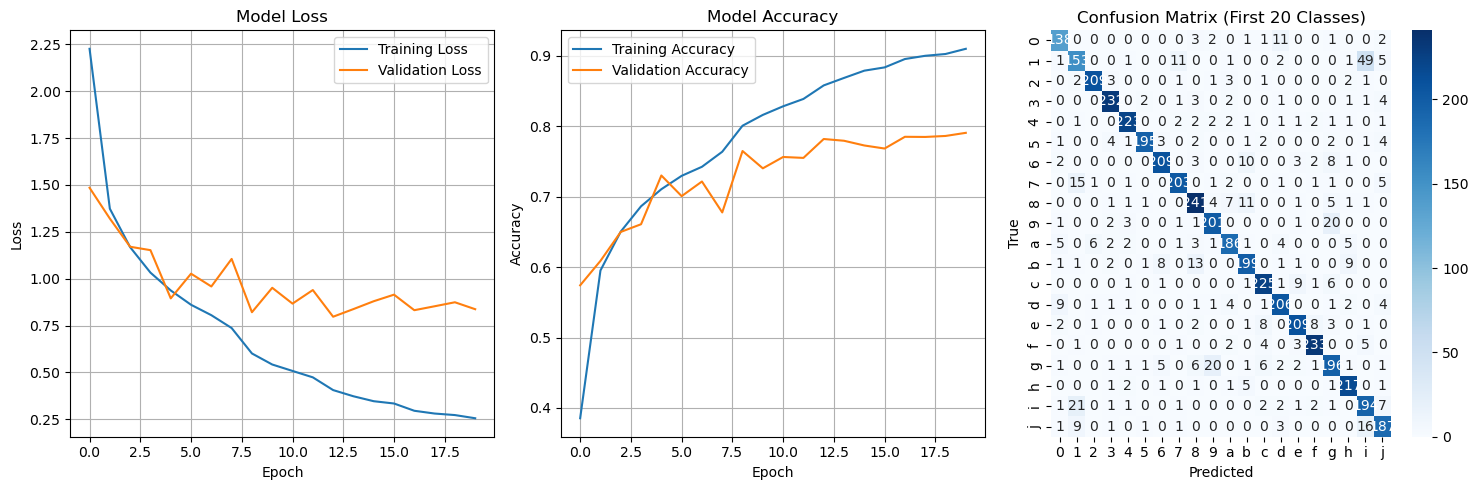


Classification Report (First 10 classes):
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       265
           1       0.66      0.58      0.61       265
           2       0.89      0.83      0.86       253
           3       0.90      0.91      0.91       255
           4       0.88      0.84      0.86       264
           5       0.85      0.80      0.82       243
           6       0.88      0.85      0.87       246
           7       0.86      0.83      0.85       244
           8       0.83      0.83      0.83       289
           9       0.81      0.82      0.81       246

   micro avg       0.82      0.78      0.80      2570
   macro avg       0.82      0.78      0.80      2570
weighted avg       0.81      0.78      0.80      2570



d:\software\Anaconda\envs\CS4243_lab\Lib\site-packages\sklearn\metrics\_classification.py:2964: UserWarning: labels size, 10, does not match size of target_names, 36
  warnings.warn(


In [10]:
# Model evaluation and visualization
if len(X) > 0 and 'history' in locals():
    # Evaluate on validation set
    print("Evaluating model on validation set...")
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
    
    # Get predictions for detailed analysis
    y_pred_proba = model.predict(X_val)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    print(f"\nValidation Results:")
    print(f"Loss: {val_loss:.4f}")
    print(f"Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    
    # Plot training progress
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Confusion matrix (first 20 classes for readability)
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    cm_subset = cm[:20, :20]
    characters_subset = CHARACTERS[:20]
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', 
                xticklabels=characters_subset, yticklabels=characters_subset)
    plt.title('Confusion Matrix (First 20 Classes)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    # Classification report for key metrics
    print("\nClassification Report (First 10 classes):")
    report = classification_report(y_true, y_pred, target_names=CHARACTERS, 
                                 labels=range(10), zero_division=0)
    print(report)
    
else:
    print("Cannot evaluate: No training history available!")

## 9. Training Progress Visualization

Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


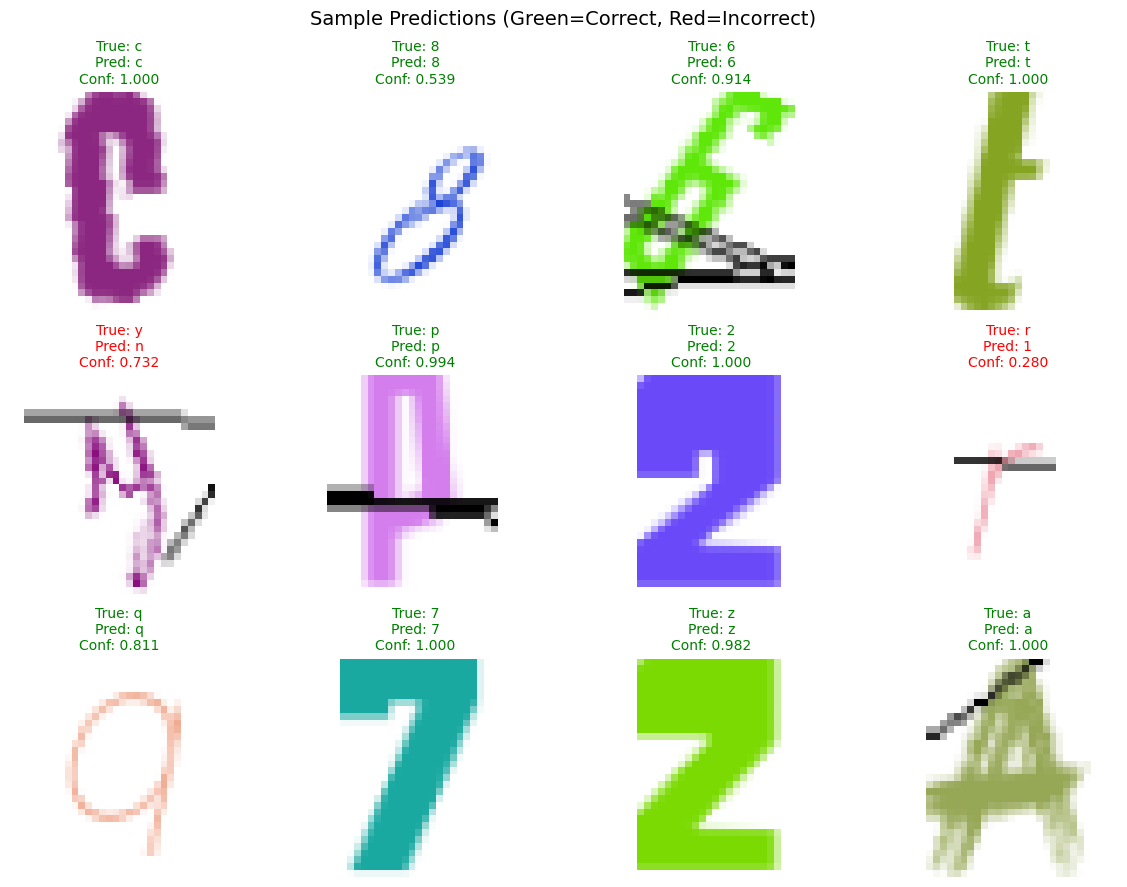

In [11]:
# Sample predictions visualization
if len(X) > 0 and 'model' in locals():
    # Show sample predictions
    def show_sample_predictions(num_samples=12):
        # Get random samples from validation set
        indices = np.random.choice(len(X_val), num_samples, replace=False)
        sample_images = X_val[indices]
        sample_labels = y_val[indices]
        
        # Get predictions
        predictions = model.predict(sample_images)
        pred_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(sample_labels, axis=1)
        
        # Plot samples
        fig, axes = plt.subplots(3, 4, figsize=(12, 9))
        axes = axes.ravel()
        
        for i in range(num_samples):
            # Get labels
            true_char = CHARACTERS[true_labels[i]]
            pred_char = CHARACTERS[pred_labels[i]]
            confidence = predictions[i][pred_labels[i]]
            
            # Determine color (green for correct, red for incorrect)
            color = 'green' if true_char == pred_char else 'red'
            
            # Plot
            axes[i].imshow(sample_images[i])
            axes[i].set_title(f'True: {true_char}\nPred: {pred_char}\nConf: {confidence:.3f}', 
                            color=color, fontsize=10)
            axes[i].axis('off')
        
        plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    print("Sample Predictions:")
    show_sample_predictions(12)
else:
    print("Cannot show predictions: No model available!")

## 10. Save Model

In [ ]:
# Save model and training summary
if len(X) > 0 and 'model' in locals():
    # Create models directory if it doesn't exist
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    
    # Save the model
    model_save_path = MODEL_SAVE_DIR / 'cnn_character_recognition.h5'
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")
    
    # Training summary
    print(f"\nTraining Summary:")
    print(f"Model Architecture: 3-layer CNN with BatchNormalization")
    print(f"Total Parameters: {model.count_params():,}")
    print(f"Training Time: {training_time:.1f} seconds")
    print(f"Epochs Trained: {len(history.history['accuracy'])}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Dataset Size: {len(X)} samples")
    
    print(f"\nCNN Character Recognition Model Training Completed Successfully!")
else:
    print("Cannot save: No model available!")

Model saved to: ..\models\saved_models\cnn_character_recognition.h5

Training Summary:
Model Architecture: 3-layer CNN with BatchNormalization
Total Parameters: 234,724
Training Time: 382.9 seconds
Epochs Trained: 20
Final Training Accuracy: 0.9099
Final Validation Accuracy: 0.7906
Best Validation Accuracy: 0.7906
Dataset Size: 46244 samples

CNN Character Recognition Model Training Completed Successfully!
